### Causal Inference on Corn Yield: The Impact of High Temperature

Crop yields are influenced by various environmental factors. To help farmers optimize yields effectively, it is important to identify which variables have the most significant impact and prioritize them based on cost and feasibility of control.

This project applies causal inference methods to quantify the impact of high temperature on corn yield. Using a global corn species dataset sourced from Kaggle, the study controls for possible confounders to satisfy the ignorability assumption, ensuring reliable causal estimates.

Specifically, temperature values in the upper quartile are treated as the "treatment" group, while those in the lower quartile serve as the control group. The median temperature in the upper quartile is 25°C, and in the lower quartile, it is 5°C.

The primary goal is to estimate how much higher temperatures (upper quartile) affect corn yield compared to lower temperatures (lower quartile). The findings provide actionable insights for farmers, enabling them to regulate greenhouse temperatures and maximize crop yield efficiently.

In [ ]:
# add a picture of corn field


In [1]:
# Inside causal-inference.ipynb

# Make sure your data_cleaning.py is in the same folder or in your PYTHONPATH

from data_cleaning import load_data, clean_data

df = load_data("climate_change_impact_on_agriculture_2024.csv")
df_clean = clean_data(df)

# Now use df_clean for your causal inference

ModuleNotFoundError: No module named 'data_cleaning'

In [164]:
# from this dataset, for 6 variables, i will do propensity score matching and see how much temperature has an impact on crop yield
# select relevant columns for propensity score matching

# filter for just corn from df
psm_data = df[df['Crop_Type'] == 'Corn'][['Total_Precipitation_mm', 'Average_Temperature_C', 'Irrigation_Access_percent', 'Fertilizer_Use_KG_per_HA', 'Soil_Health_Index', 'Crop_Yield_MT_per_HA']]

# drop rows with missing values
psm_data = psm_data.dropna()

# create a binary treatment variable based on Average_Temperature_C, select 3rd quartile and higher as treatmnt group and frist quartile and lower as control group
treatment_threshold = psm_data['Average_Temperature_C'].quantile(0.75)

# craete antoehr threshold at 25th percentile for control group
control_threshold = psm_data['Average_Temperature_C'].quantile(0.25)

# print the thresholds
print("Treatment Threshold (75th percentile):", treatment_threshold)
print("Control Threshold (25th percentile):", control_threshold)

Treatment Threshold (75th percentile): 25.0925
Control Threshold (25th percentile): 5.745


In [165]:
# create new column assignment treatment group if greater than treatment threshold, treatment group if less than control threshold, and control group otherwise
import numpy as np

psm_data['Treatment'] = np.where(
    psm_data['Average_Temperature_C'] >= treatment_threshold, 1,
    np.where(psm_data['Average_Temperature_C'] <= control_threshold, 0, np.nan)
)

# print the first few rows of the psm_data
print(psm_data.head())

    Total_Precipitation_mm  Average_Temperature_C  Irrigation_Access_percent  \
0                   447.06                   1.55                      14.54   
1                  2913.57                   3.23                      11.05   
27                 1433.31                  15.75                      79.20   
66                 2317.59                  15.76                      94.85   
67                 2310.19                   9.97                      19.87   

    Fertilizer_Use_KG_per_HA  Soil_Health_Index  Crop_Yield_MT_per_HA  \
0                      14.78              83.25                 1.737   
1                      23.25              54.02                 1.737   
27                     67.56              55.03                 2.080   
66                     35.76              48.60                 3.807   
67                      5.83              97.48                 1.053   

    Treatment  
0         0.0  
1         0.0  
27        NaN  
66        NaN  


In [166]:
print(psm_data[['Treatment', 'Total_Precipitation_mm', 'Average_Temperature_C', 'Irrigation_Access_percent', 'Fertilizer_Use_KG_per_HA', 'Soil_Health_Index']].isnull().sum())

# remote rows with missing values in the Treatment column
psm_data = psm_data.dropna(subset=['Treatment'])

# check data type for all columns
print(psm_data.dtypes)

Treatment                    510
Total_Precipitation_mm         0
Average_Temperature_C          0
Irrigation_Access_percent      0
Fertilizer_Use_KG_per_HA       0
Soil_Health_Index              0
dtype: int64
Total_Precipitation_mm       float64
Average_Temperature_C        float64
Irrigation_Access_percent    float64
Fertilizer_Use_KG_per_HA     float64
Soil_Health_Index            float64
Crop_Yield_MT_per_HA         float64
Treatment                    float64
dtype: object


In [171]:
psm_data['Treatment'] = psm_data['Treatment'].astype(int)

# check the data types again for treatment column
print(psm_data.dtypes)


Total_Precipitation_mm       float64
Average_Temperature_C        float64
Irrigation_Access_percent    float64
Fertilizer_Use_KG_per_HA     float64
Soil_Health_Index            float64
Crop_Yield_MT_per_HA         float64
Treatment                      int64
dtype: object


In [ ]:
import statsmodels.formula.api as smf

psm_model = smf.logit(
    'Treatment ~ Total_Precipitation_mm + Fertilizer_Use_KG_per_HA + Irrigation_Access_percent + Soil_Health_Index',
    data=psm_data
).fit()

# add the value in propensity score column
psm_data['Propensity_Score'] = psm_model.predict(psm_data)

# print the first few rows of psm_data with propensity score
print(psm_data['Propensity_Score'].head())

# count total rows
print("Total rows after adding propensity score:", psm_data.shape[0])

Optimization terminated successfully.
         Current function value: 0.690624
         Iterations 4
0      0.453382
1      0.510675
90     0.454152
99     0.541879
125    0.520484
Name: Propensity_Score, dtype: float64
Total rows after adding propensity score: 512


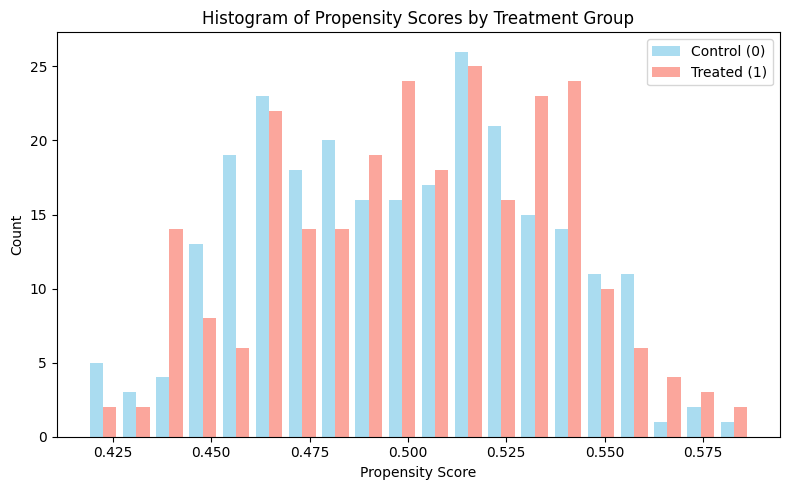

In [ ]:
import matplotlib.pyplot as plt

# Split by treatment status
treated = psm_data[psm_data['Treatment'] == 1]['Propensity_Score']
control = psm_data[psm_data['Treatment'] == 0]['Propensity_Score']

# Plot
plt.figure(figsize=(8, 5))
plt.hist([control, treated], bins=20, label=['Control (0)', 'Treated (1)'], color=['skyblue', 'salmon'], alpha=0.7)
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.title('Histogram of Propensity Scores by Treatment Group')
plt.legend()
plt.tight_layout()
plt.show()

In [199]:
# let do propensity score matching using nearest neighbor matching
from sklearn.neighbors import NearestNeighbors
# Separate treated and control groups
treated = psm_data[psm_data['Treatment'] == 1]
control = psm_data[psm_data['Treatment'] == 0]
# Initialize NearestNeighbors model
nn = NearestNeighbors(n_neighbors=1)
# Fit the model on the propensity scores of the control group
nn.fit(control[['Propensity_Score']])
# Find the nearest neighbors for the treated group
distances, indices = nn.kneighbors(treated[['Propensity_Score']])
# Get the matched control group
matched_control = control.iloc[indices.flatten()]
# Combine treated and matched control groups
matched_data = pd.concat([treated, matched_control], ignore_index=True)    

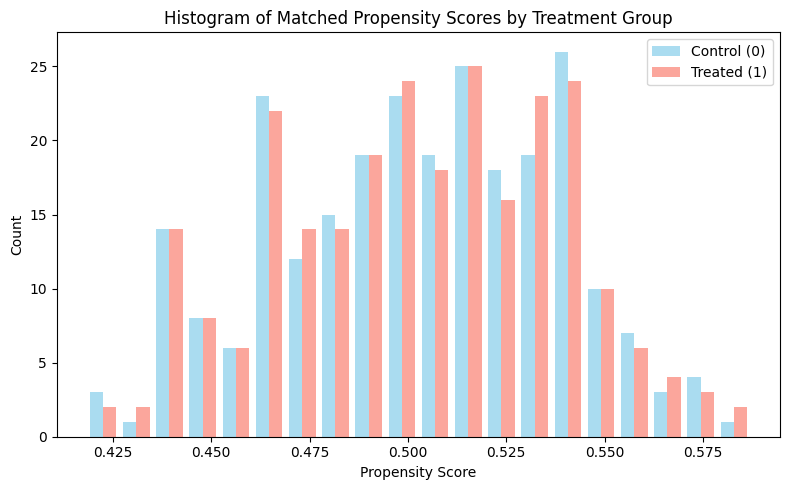

In [200]:
# plot the matched data
plt.figure(figsize=(8, 5))
plt.hist([matched_control['Propensity_Score'], treated['Propensity_Score']], bins=20, label=['Control (0)', 'Treated (1)'], color=['skyblue', 'salmon'], alpha=0.7)
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.title('Histogram of Matched Propensity Scores by Treatment Group')
plt.legend()
plt.tight_layout()
plt.show()

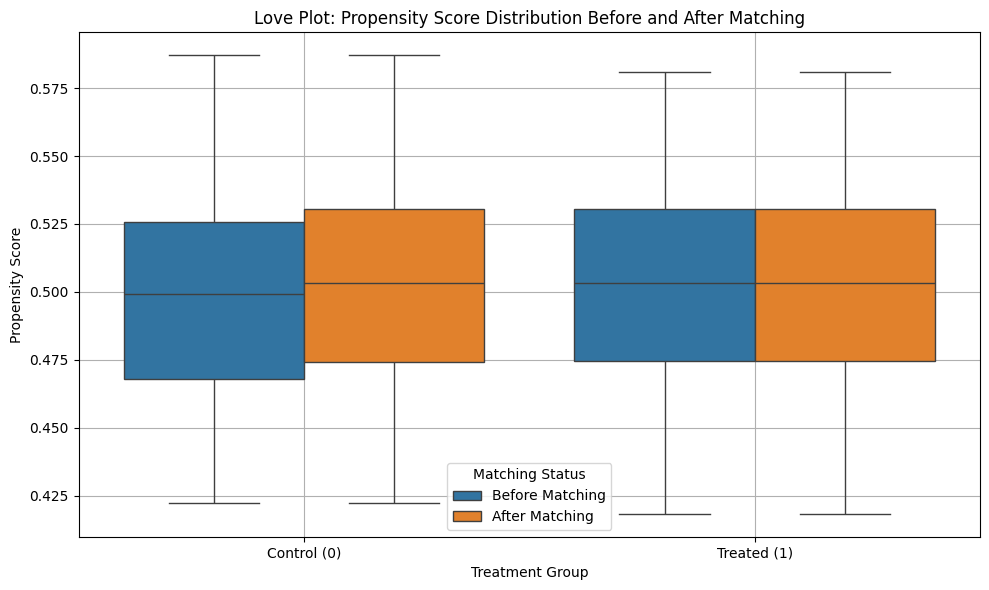

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add matching status column
psm_data['Matching_Status'] = 'Before Matching'
matched_data['Matching_Status'] = 'After Matching'

# Combine both datasets
combined = pd.concat([psm_data, matched_data], ignore_index=True)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Treatment', y='Propensity_Score', hue='Matching_Status', data=combined)
plt.title('Love Plot: Propensity Score Distribution Before and After Matching')
plt.xlabel('Treatment Group')
plt.ylabel('Propensity Score')
plt.xticks([0, 1], ['Control (0)', 'Treated (1)'])
plt.legend(title='Matching Status')
plt.grid(True)
plt.tight_layout()
plt.show()


In [201]:
# print the matched data
print(matched_data.head())

   Total_Precipitation_mm  Average_Temperature_C  Irrigation_Access_percent  \
0                 1836.63                  32.28                      37.67   
1                 1704.94                  25.49                      48.66   
2                 2108.28                  32.57                      65.66   
3                 2816.57                  34.88                      54.64   
4                 2395.28                  28.55                      30.69   

   Fertilizer_Use_KG_per_HA  Soil_Health_Index  Crop_Yield_MT_per_HA  \
0                     29.79              35.55                 3.420   
1                     64.11              45.40                 1.611   
2                     11.06              86.38                 3.141   
3                     58.32              53.06                 1.035   
4                      9.43              31.11                 2.170   

   Treatment  Propensity_Score  
0          1          0.541879  
1          1          0.52

In [ ]:
# calcuate average treatment effect on the treated (ATT)
att = matched_data[matched_data['Treatment'] == 1]['Crop_Yield_MT_per_HA'].mean() - matched_data[matched_data['Treatment'] == 0]['Crop_Yield_MT_per_HA'].mean()

# print the average treatment effect on the treated
print("Average Treatment Effect on the Treated (ATT):", att)

Average Treatment Effect on the Treated (ATT): 0.6448906249999999


In [ ]:
# check the statistical significance of the ATT using a t-test
from scipy import stats
t_stat, p_value = stats.ttest_ind(
    matched_data[matched_data['Treatment'] == 1]['Crop_Yield_MT_per_HA'],
    matched_data[matched_data['Treatment'] == 0]['Crop_Yield_MT_per_HA']
)
# print the t-statistic and p-value
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: 9.368879292115368
P-value: 2.359553113714145e-19


After adjusting for relevant confounding variables using propensity score matching, we found that the treatment (or temperature) has a statistically significant effect on the outcome. Specifically, the Average Treatment Effect on the Treated (ATT) is approximately 0.645 metric tons per hectare increase in crop yield.

The associated p-value is less than 0.05, indicating that this effect is statistically significant at the 5% level — meaning the observed effect is unlikely to have occurred by chance.

This suggests that, for the treated group, exposure to this treatment (or increase in temperature) leads to a meaningful increase in crop yield compared to if they had not received the treatment.